In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from docplex.mp.model import Model
import math

In [2]:
file_path = 'dataset.txt'
column_names = ["CUST NO.", "XCOORD.", "YCOORD.", "DEMAND", "READY TIME", "DUE DATE", "SERVICE TIME"]

df = pd.read_csv(file_path, delim_whitespace=True, names=column_names)

number_of_customers=30
df = df.head(number_of_customers+1)

df.head()

,CUST NO.,XCOORD.,YCOORD.,DEMAND,READY TIME,DUE DATE,SERVICE TIME
0,1,35.0,35.0,0.0,0.0,230.0,0.0
1,2,41.0,49.0,10.0,161.0,171.0,10.0
2,3,35.0,17.0,7.0,50.0,60.0,10.0
3,4,55.0,45.0,13.0,116.0,126.0,10.0
4,5,55.0,20.0,19.0,149.0,159.0,10.0


In [3]:
xc = df['XCOORD.'].values
yc = df['YCOORD.'].values

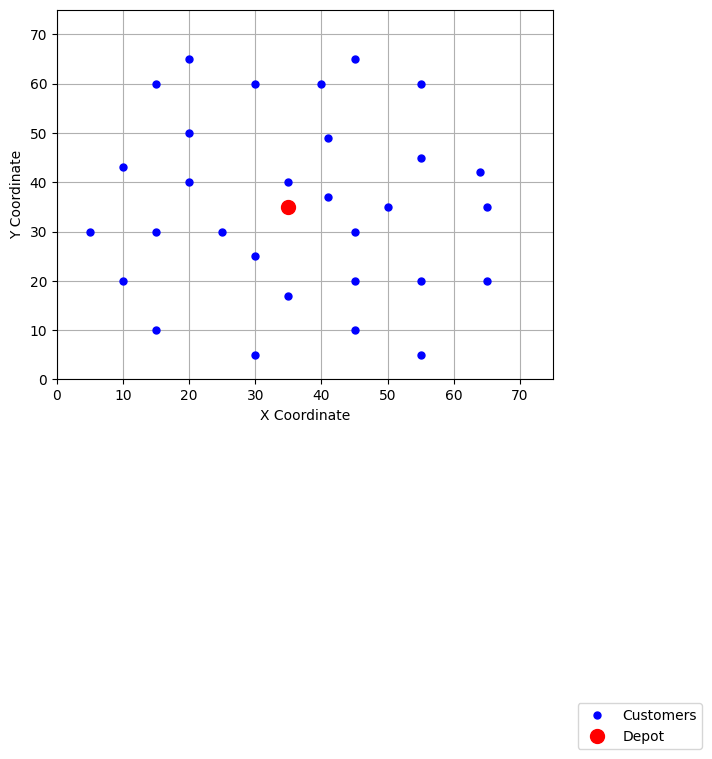

In [4]:
plt.plot(df["XCOORD."], df["YCOORD."], ".", color="blue", markersize=10, label="Customers")
plt.plot(df["XCOORD."][0], df["YCOORD."][0], "o", color="red", markersize=10, label="Depot")

plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
#plt.title(f"Geographical Distribution of {number_of_customers} customers")

plt.axis([0,75,0,75])

plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, -1), loc='lower left', borderaxespad=0.)
plt.plot()

plt.savefig(f"vrp_{number_of_customers}c.png")

In [5]:
n = len(df)-1
N = [i for i in range(1, n+1)]
V = [0] + N
A = [(i, j) for i in V for j in V if i != j]
c = {(i, j): np.hypot(xc[i]-xc[j], yc[i]-yc[j]) for i, j in A}
st = df['SERVICE TIME'].values
t = {(i,j): c[(i,j)] + st[j] for i, j in A}
Q = 200
q = df['DEMAND'].values
timelimit = 5

In [6]:
mdl = Model('CVRP')

In [7]:
x = mdl.binary_var_dict(A, name='x')
u = mdl.continuous_var_dict(N, ub=Q, name='u')

In [8]:
mdl.minimize(mdl.sum(t[i, j]*x[i, j] for i, j in A))
mdl.add_constraints(mdl.sum(x[i, j] for j in V if j != i) == 1 for i in N)
mdl.add_constraints(mdl.sum(x[i, j] for i in V if i != j) == 1 for j in N)
mdl.add_indicator_constraints(mdl.indicator_constraint(x[i, j], u[i]+q[j] == u[j]) for i, j in A if i != 0 and j != 0)
mdl.add_constraints(u[i] >= q[i] for i in N)
mdl.parameters.timelimit = timelimit
solution = mdl.solve(log_output=True)

Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               5
Found incumbent of value 1701.825901 after 0.00 sec. (0.09 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 30 rows and 0 columns.
MIP Presolve modified 435 coefficients.
Aggregator did 435 substitutions.
Reduced MIP has 495 rows, 1395 columns, and 3105 nonzeros.
Reduced MIP has 930 binaries, 0 generals, 0 SOSs, and 870 indicators.
Presolve time = 0.05 sec. (4.26 ticks)
Probing time = 0.03 sec. (8.78 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 495 rows, 1395 columns, and 3105 nonzeros.
Reduced MIP has 930 binaries, 0 generals, 0 SOSs, and 870 indicators.
Presolve time = 0.02 sec. (2.25 ticks)
Probing time = 0.02 sec. (2.45 ticks)
Clique table members: 495.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root 

In [9]:
#print(solution)
#solution.solve_status

In [10]:
active_arcs = [a for a in A if x[a].solution_value > 0.9]

In [11]:
def find_loops(list_of_tuples, loops2):
    # Initialize a dictionary to store the loops
    loops = {}

    # Loop through the list of tuples
    for item in list_of_tuples:
        # Check if the item is a tuple
        if isinstance(item, tuple):
            # If the tuple starts with zero, create a new loop
            if item[0] == 0:
                loop = [item]
                current_node = item[1]
                # Traverse the list to find the rest of the loop
                while current_node != 0:
                    for i in list_of_tuples:
                        if isinstance(i, tuple) and i[0] == current_node:
                            loop.append(i)
                            current_node = i[1]
                            break
                # Store the loop in the dictionary
                loops[item] = loop

    # Print the loops
    for key, value in loops.items():
        print("Loop starting at", key, ":", value)
    
    for key, value in loops.items():
        loops2.append(value)

    return loops2


# Example list of tuples
list_of_tuples = active_arcs
list_of_loops_2 = []


# Find and print the loops
find_loops(list_of_tuples, list_of_loops_2)


Loop starting at (0, 3) : [(0, 3), (3, 29), (29, 24), (24, 25), (25, 4), (4, 23), (23, 22), (22, 21), (21, 26), (26, 12), (12, 28), (28, 0)]
Loop starting at (0, 13) : [(0, 13), (13, 2), (2, 15), (15, 14), (14, 16), (16, 17), (17, 5), (5, 6), (6, 0)]
Loop starting at (0, 18) : [(0, 18), (18, 8), (8, 7), (7, 19), (19, 11), (11, 10), (10, 30), (30, 20), (20, 9), (9, 1), (1, 27), (27, 0)]


[[(0, 3),
  (3, 29),
  (29, 24),
  (24, 25),
  (25, 4),
  (4, 23),
  (23, 22),
  (22, 21),
  (21, 26),
  (26, 12),
  (12, 28),
  (28, 0)],
 [(0, 13),
  (13, 2),
  (2, 15),
  (15, 14),
  (14, 16),
  (16, 17),
  (17, 5),
  (5, 6),
  (6, 0)],
 [(0, 18),
  (18, 8),
  (8, 7),
  (7, 19),
  (19, 11),
  (11, 10),
  (10, 30),
  (30, 20),
  (20, 9),
  (9, 1),
  (1, 27),
  (27, 0)]]

In [12]:
color_vector = [
    '#6699FF',  # light blue
    '#ffc559',  # light orange
    '#93e493',  # light green
]

color_vector2 = [
    '#3075ff',  # blue
    '#ffa500',  # orange
    '#228B22'   # green
]

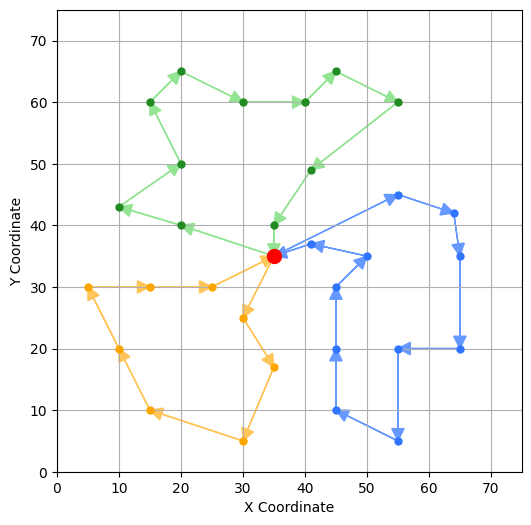

In [13]:
plt.figure(figsize=[6, 6])

plt.axis([0,75,0,75])

for k in range(len(list_of_loops_2)):
    for i,j in list_of_loops_2[k]:
        plt.arrow(xc[i] , yc[i], xc[j]-xc[i], yc[j]-yc[i], head_width=2, head_length=2, color=color_vector[k], length_includes_head=True)
        plt.plot(df["XCOORD."][i], df["YCOORD."][i], ".", color=color_vector2[k], markersize=10)

plt.plot(df["XCOORD."][0], df["YCOORD."][0], "o", color="red", markersize=10, label="Starting Point")

plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
#plt.title(f"Geographical Distribution of {number_of_customers} customers")


plt.grid(True)
#plt.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
plt.plot()

plt.savefig(f"vrp_{number_of_customers}c_{timelimit}s_solution.svg")